# kaggle competition report

#### 在這次作業的競賽中，我嘗試了許多方法來得到比較好的結果，接下來我會一一對其介紹，主要會分為
1. Naive bayes(兩種encode方法) 
2. LSTM 
3. MLPClassfier 
4. MLPReggressor 
5. 其他嘗試

## 1.Naive bayes

一開始我們必須對資料做一些前處理，所以這一步驟我們先讀入檔案

In [75]:
import pandas as pd
import json
import numpy as np

# 定義一個函數來讀取 JSON 檔案
id_list=[]
text_list=[]
score_list=[]
with open('tweets_DM.json') as f:
    into_list=f.readlines()
    for data_json in into_list:
        data=json.loads(data_json)
        score_list.append(data['_score'])
        id_list.append(data['_source']['tweet']['tweet_id'])
        text_list.append(data['_source']['tweet']['text'])
data_tweet={"tweet_id":id_list,"text":text_list,"score":score_list}
df_all=pd.DataFrame(data_tweet)

# 讀取檔案
emotion = pd.read_csv('emotion.csv')
data_identification = pd.read_csv('data_identification.csv')

將資料merge在一起，方便後續處理

In [77]:
df_all=pd.merge(df_all,data_identification,on='tweet_id',how='outer')
df_all= pd.merge(df_all,emotion,on='tweet_id',how= 'outer')
print(df_all.head())

   tweet_id                                               text     score  \
0  0x376b20  People who post "add me on #Snapchat" must be ...  0.381232   
1  0x2d5350  @brianklaas As we see, Trump is dangerous to #...  0.422287   
2  0x28b412  Confident of your obedience, I write to you, k...  0.225806   
3  0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>  0.366569   
4  0x2de201  "Trust is not the same as faith. A friend is s...  0.965787   

  identification       emotion  
0          train  anticipation  
1          train       sadness  
2           test           NaN  
3          train          fear  
4           test           NaN  


對我們的text做一些前處理，像是移除特殊符號及停用詞還有做了類似 stemming 的概念，最後將文本重新組合

In [13]:
import nltk
from nltk.corpus import stopwords
import regex as re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
stopwords.words('english')
lemmmatizer=WordNetLemmatizer()
clean_txt=[]

for text in list(df_all['text']):
    text=re.sub('[<LH>"\'.,]','',text)
    text=re.sub('@\\w+ *','',text)
    text=text.lower()
    text = text.split()
    text = [lemmmatizer.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    clean_txt.append(text)
df_all['text']=clean_txt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nick2\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nick2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


接著我發現分數這一行的數值很大，所以對其進行正規化(雖然之後沒有使用到這個feature XD)，再將整理好的資料儲存起來，之後就能隨時呼叫

In [15]:
def minmax_norm(df_input):
    return (df_input - df_input.min()) / (df_input.max() - df_input.min())
df_all["score"] = minmax_norm(df_all["score"])
df_all.to_csv('kaggle_data_preprocess.csv')

## 前面是前處理，正常從這邊開始執行

先讀入已經處理好的資料文本，並刪除一些空白的資訊

In [64]:
import pandas as pd
df_all=pd.read_csv('kaggle_data_preprocess.csv')
df_all.drop(['Unnamed: 0'],axis=1,inplace=True)
df_all.head()

,tweet_id,text,score,identification_x,emotion_x,identification_y,emotion_y
0,0x376b20,people post add #snapchat must dehydrated cuz ...,0.381232,train,anticipation,train,anticipation
1,0x2d5350,see trump dangerous #freepress around world #t...,0.422287,train,sadness,train,sadness
2,0x28b412,confident obedience write knowing even ask (ph...,0.225806,test,NaN,test,NaN
3,0x1cd5b0,issa stalking tasha 😂😂😂,0.366569,train,fear,train,fear
4,0x2de201,trust faith friend someone trust putting faith...,0.965787,test,NaN,test,NaN


根據 identification 的類別，將資料分為 train 跟 test，並清理掉一些 text 為空白的資訊

In [65]:
train_data = df_all[df_all['identification_y'] == 'train']
test_data = df_all[df_all['identification_y'] == 'test']
print(train_data.shape)
print(test_data.shape)
train_data=train_data.dropna(subset=["text"])
test_data=test_data.dropna(subset=['text'])
print(train_data.shape)
print(test_data.shape)

(1455563, 7)
(411972, 7)
(1452595, 7)
(411953, 7)


使用上課所教的 TFIDF 技術，創建一個 TF-IDF 向量化器，指定最大特徵數為 25000，並使用 NLTK 的 word_tokenize 函數進行分詞

這一部分非常重要，將文本轉為數值，方便我們之後進行訓練

In [66]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
df_all_not_na = df_all.dropna(subset=["text"])
vectorizer_2 = TfidfVectorizer(max_features=25000,tokenizer=nltk.word_tokenize)
tf_idf_all_2 = vectorizer_2.fit(df_all_not_na['text'])
X_train = tf_idf_all_2.transform(train_data['text'])
y_train = train_data['emotion_y']

X_test = tf_idf_all_2.transform(test_data['text'])
y_test = test_data['emotion_y']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nick2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\nick2\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1452595, 20000)
y_train.shape:  (1452595,)
X_test.shape:  (411953, 20000)
y_test.shape:  (411953,)


將向量化之後的資料儲存起來，方便下次免去前面處理的步驟

In [67]:
from scipy import sparse

sparse.save_npz("data/X_train.npz", X_train)
sparse.save_npz("data/X_test.npz", X_test)

## 訓練從這開始

重新呼叫之前處理好的數據

In [78]:
from scipy import sparse
import pandas as pd

df_all=pd.read_csv('kaggle_data_preprocess.csv')

df_all.drop(['Unnamed: 0'],axis=1,inplace=True)

train_data = df_all[df_all['identification_y'] == 'train']
test_data = df_all[df_all['identification_y'] == 'test']
train_data=train_data.dropna(subset=["text"])
test_data=test_data.dropna(subset=['text'])

X_train = train_data[['text']]
y_train = train_data['emotion_y']

X_test = test_data[['text']]
y_test = test_data['emotion_y']

         Unnamed: 0  tweet_id  \
0                 0  0x376b20   
1                 1  0x2d5350   
2                 2  0x28b412   
3                 3  0x1cd5b0   
4                 4  0x2de201   
...             ...       ...   
1867530     1867530  0x316b80   
1867531     1867531  0x29d0cb   
1867532     1867532  0x2a6a4f   
1867533     1867533  0x24faed   
1867534     1867534  0x34be8c   

                                                      text     score  \
0        people post add #snapchat must dehydrated cuz ...  0.381232   
1        see trump dangerous #freepress around world #t...  0.422287   
2        confident obedience write knowing even ask (ph...  0.225806   
3                                  issa stalking tasha 😂😂😂  0.366569   
4        trust faith friend someone trust putting faith...  0.965787   
...                                                    ...       ...   
1867530  buy last 2 ticket remaining show sell #mixedfe...  0.807429   
1867531                swea

# MultinomialNB

這邊我用了一個基於多項式朴素貝葉斯的文本分類模型，並使用 TF-IDF 特徵進行訓練和預測。最後，透過分類報告評估模型在訓練集上的性能

In [69]:
from scipy import sparse
X_train = sparse.load_npz("data/X_train.npz")
X_test = sparse.load_npz("data/X_test.npz")

# 呼叫模型
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train) #進行訓練
y_train_pred_NB=clf.predict(X_train)
y_test_pred_NB=clf.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_true=y_train, y_pred=y_train_pred_NB))

              precision    recall  f1-score   support

       anger       0.87      0.13      0.22     39817
anticipation       0.65      0.46      0.54    248708
     disgust       0.53      0.34      0.41    138764
        fear       0.82      0.26      0.40     63921
         joy       0.49      0.88      0.63    514581
     sadness       0.50      0.44      0.47    193048
    surprise       0.82      0.13      0.22     48642
       trust       0.65      0.19      0.30    205114

    accuracy                           0.53   1452595
   macro avg       0.66      0.35      0.40   1452595
weighted avg       0.58      0.53      0.49   1452595



因為我們前面有刪除一些 text 為空白的資訊，所以我們的 submission 會少一些維度，所以這邊必須對其做一些處理

In [70]:
df_test = df_all[df_all['identification_y'] == 'test'].dropna(subset=['text'])
y_test_pred_NB=pd.DataFrame(y_test_pred_NB)
y_submit=df_test.copy()
y_submit['emotion_y']=list(y_test_pred_NB[0])
y_submit.drop(labels=['text','score','identification_x','identification_y','emotion_x'],axis=1,inplace=True)
y_submit.rename(columns={"tweet_id": "id"},inplace=True)

In [71]:
df_test = df_all[df_all['identification_y'] == 'test']
del df_test['emotion_x']
del df_test['score']
del df_test['identification_y']
del df_test['identification_x']
df_test

,tweet_id,text,emotion_y
2,0x28b412,confident obedience write knowing even ask (ph...,NaN
4,0x2de201,trust faith friend someone trust putting faith...,NaN
9,0x218443,enough ? satisfied ? goal really money ? #mate...,NaN
30,0x2939d5,god woke chase day #godsplan #godswork,NaN
33,0x26289a,tough time turn symbol hope?,NaN
...,...,...,...
1867525,0x2913b4,message ye heard beginning love one another jo...,NaN
1867529,0x2a980e,lad hath five barley loaf two small fishes: am...,NaN
1867530,0x316b80,buy last 2 ticket remaining show sell #mixedfe...,NaN
1867531,0x29d0cb,swear hard work gone pay one day😈💰💸,NaN


這邊我們將所有空白 text 的設定為 anticipation，並加入到我們的 submission 中

In [72]:
add=df_test[df_test['text'].isna()].copy()
add['emotion_y']='anticipation'
add.rename(columns={'tweet_id':'id'},inplace=True)
y_submit=pd.concat([y_submit,add])

In [73]:
y_submit.drop(labels=['text'],axis=1,inplace=True)
y_submit.rename(columns={'tweet_id':'id','emotion_y':'emotion'},inplace=True)
y_submit

,id,emotion
2,0x28b412,anticipation
4,0x2de201,anticipation
9,0x218443,joy
30,0x2939d5,anticipation
33,0x26289a,joy
...,...,...
1034643,0x266e68,anticipation
1328136,0x269579,anticipation
1351856,0x2f885c,anticipation
1443448,0x20d80b,anticipation


將最終結果存成 csv 黨

In [74]:
y_submit.to_csv('submission.csv',index=False)

我們使用了這個方法最終也得到 0.44441 的分數，我雖然我也有使用 W2V 的方式來進行轉換，但效果似乎沒有差距太多，還是Tfidf的表現好一點，而我有嘗試調大TfidfVectorizer的 maxfeature ，最終表現上也會有些微的提升，而且使用到 lab 所教的技術，我覺得很不錯。
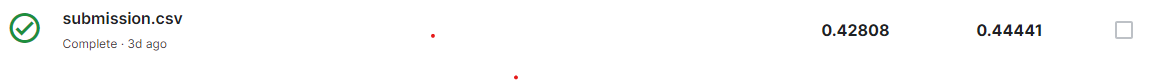

# 2. LSTM

接著我嘗試了 LSTM 模型，因為 LSTM 是一種深度學習中的循環神經網絡（RNN）架構，專門設計來處理序列數據和解決長期相依性問題。在自然語言處理（NLP）、語音識別、時間序列分析等領域，LSTM廣泛應用於處理和建模具有長期相依性的數據。它在序列建模任務中的表現通常優於傳統的 RNN 模型。近年來，LSTM 的一些變種和更先進的序列模型（如 Transformer）也取得了顯著的進展。

首先讀入我們的data

In [ ]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
#import Package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from datasets import load_dataset
from datasets import Dataset

#Read Json File
tweet_raw = load_dataset("json", data_files="/kaggle/input/dm2023/tweets_DM.json")
tweet_raw = tweet_raw['train']['_source']

#Read CSV data
data_iden = pd.read_csv('/kaggle/input/dm2023/data_identification.csv')
data_label = pd.read_csv('/kaggle/input/dm2023/emotion.csv')

#Transform to pandas dataframe for later preprocessing
tweet_df = pd.json_normalize(tweet_raw)
tweet_df.columns= ['hashtags','tweet_id','text_raw']
tweet_df = tweet_df.join(data_iden.set_index('tweet_id'), on='tweet_id')
tweet_df = tweet_df.join(data_label.set_index('tweet_id'), on='tweet_id')
tweet_df.head()

接著我們先預處理我們的 text ，例如利用 emoji 將文本中的表情符號轉換為對應的文字描述，和替換文字中的特殊字元，並將處理後的文本以空格為分隔符拆分成單詞，最後將處理後的文本列表中的單詞連接成一個字符串，並返回最終的預處理文本

In [ ]:
import re
import emoji

def preprocess(text):
    new_text = []
    text = emoji.demojize(text).replace('face_with_',' ').replace('_',' ').replace(':',' ')
    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = 'website' if t.startswith('http') else t
        t = t.replace('#','').replace('<LH>','')
        t = re.sub(r'\W+', ' ', t)
        new_text.append(t.lower())
    return " ".join([i for i in new_text if i !=''])

根據 identification 的類別，將資料分為 train 跟 test，並清理掉一些 text 為空白的資訊

In [ ]:
tweet_df["text"]= tweet_df.text_raw.apply(lambda x: preprocess(x))

train_df = tweet_df[tweet_df.identification=='train']
test_df = tweet_df[tweet_df.identification=='test']
train_df = train_df.dropna(axis=1)

切分訓練跟驗證資料集

In [ ]:
#Split train and validation dataset
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(
    train_df.text, train_df.emotion,
    test_size = 0.25,   
    shuffle = True,
    random_state=42)

tweets = X_train
labels = Y_train

#Set validation dataset
val_tweets = X_val
val_labels = Y_val

從 gensim 的模型庫中下載了一個預先訓練好的 GloVe Twitter 25 維度的詞向量模型，可以將我們的text轉換成向量

In [ ]:
#import pre-trained word2vector model 
import gensim.downloader as api
w2v_model = api.load("glove-twitter-25")
w2v_model['sad']

使用訓練集文本建立了一個詞彙表。這個詞彙表將用於將文本轉換為整數序列，以便進一步用於深度學習模型的訓練

In [ ]:
#Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token='')
tokenizer.fit_on_texts(train_df.text)

根據預先訓練好的 GloVe 詞向量，為模型的嵌入層創建一個初始嵌入矩陣。這個嵌入矩陣將被用來初始化深度學習模型中的嵌入層，以便模型能夠利用預訓練的詞向量進行更好的訓練。

In [ ]:
import numpy as np

vocab_size = len(tokenizer.word_index) + 1 
word_index = tokenizer.word_index
embedding_dim = 25
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for w in word_index:
    idx = word_index[w] 
    try:
        embedding_matrix[idx] = np.array(w2v_model[w], dtype=np.float32)[:embedding_dim]
    except:
        pass

定義了一個名為 get_sequences 的函式，並使用該函式來將文本序列轉換為填充（padded）的整數序列。我們目的是將文本序列轉換為整數序列，然後進行填充以確保它們具有相同的長度，以便用於深度學習模型的訓練。

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=40, padding='post')
    return padded_sequences

padded_train_sequences = get_sequences(tokenizer, tweets)
val_sequences = get_sequences(tokenizer, val_tweets)

將文本標籤轉換為數字類別索引，並創建幾個字典以實現類別名到索引和索引到類別名的映射，為每個不同的標籤創建一個唯一的數字索引，以便在深度學習模型中使用

In [ ]:
classes = set(labels)
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])                  
train_labels = names_to_ids(labels)
val_labels = names_to_ids(Y_val)

print(classes_to_index)

使用 Keras 库建立的 LSTM 模型，並使用預訓練的嵌入層，模型架構如下：

In [6]:
print("Model: sequential")
print("_________________________________________________________________")
print(" Layer (type)                Output Shape              Param    ")
print(" embedding (Embedding)       (None, 40, 25)            12258675  ")
print(" lstm (LSTM)                 (None, 40, 128)           78848")
print(" dropout (Dropout)           (None, 40, 128)           0")
print(" lstm_1 (LSTM)               (None, 128)               131584")
print(" dense (Dense)               (None, 64)                8256")
print(" dense_1 (Dense)             (None, 8)                 520")
print("Total params: 12477883 (47.60 MB)")
print("Trainable params: 219208 (856.28 KB)")
print("Non-trainable params: 12258675 (46.76 MB)")
print("_________________________________________________________________")

Model: sequential
_________________________________________________________________
 Layer (type)                Output Shape              Param    
 embedding (Embedding)       (None, 40, 25)            12258675  
 lstm (LSTM)                 (None, 40, 128)           78848
 dropout (Dropout)           (None, 40, 128)           0
 lstm_1 (LSTM)               (None, 128)               131584
 dense (Dense)               (None, 64)                8256
 dense_1 (Dense)             (None, 8)                 520
Total params: 12477883 (47.60 MB)
Trainable params: 219208 (856.28 KB)
Non-trainable params: 12258675 (46.76 MB)
_________________________________________________________________


In [ ]:
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Flatten
from keras.layers import Embedding
import tensorflow as tf

embedding_dim = 25
maxlen = 40
model = Sequential()
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax'))
opt = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
print(model.summary())

進行訓練

In [ ]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=200,batch_size=1000,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

畫出 training 跟 validation 的 loss curve
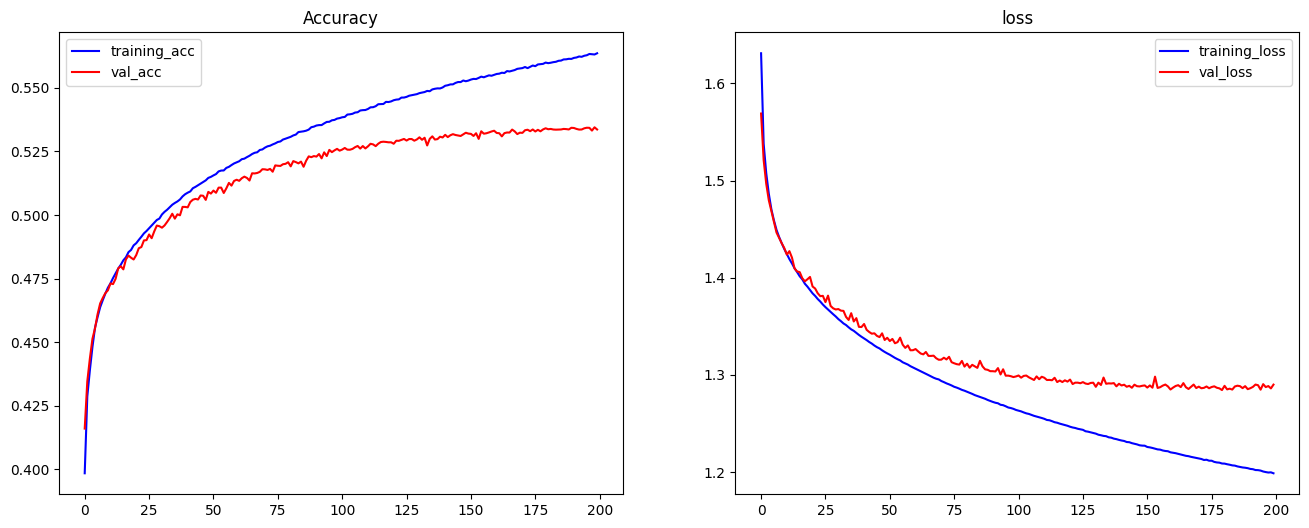

In [ ]:
acc = h.history['acc']
val_acc = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(acc, color='blue',label = 'training_acc')
plt.plot(val_acc, color='red',label = 'val_acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(loss, color='blue',label = 'training_loss')
plt.plot(val_loss, color='red',label = 'val_loss')
plt.legend()
plt.title('loss')

plt.show()

預測結果，並將其保存為 csv 黨

In [ ]:
##prdeiction 
predict_dict = {}
classes = list(classes)

#the first 10 ows
test_tweets = test_df.iloc[:10]
test_sequences = get_sequences(tokenizer, test_tweets.text)
test_logits = model.predict(test_sequences)

for i,pred in zip(test_tweets.tweet_id, test_logits):
    predict_dict.update({i:classes[pred.argmax()]})

predict_dict

In [ ]:
predict_dict = {}
classes = list(classes)

for i in range(1,int(test_df.shape[0]/10000)+1): #round(test_df.shape[0]/100)
    print((i-1)*10000,i*10000)
    test_tweets = test_df.iloc[(i-1)*10000:i*10000]
    test_sequences = get_sequences(tokenizer, test_tweets.text)
    test_logits = model.predict(test_sequences)
    
    for i,pred in zip(test_tweets.tweet_id, test_logits):
        predict_dict.update({i:classes[pred.argmax()]})
        
test_tweets = test_df.iloc[410000:]
test_sequences = get_sequences(tokenizer, test_tweets.text)
test_logits = model.predict(test_sequences)

for i,pred in zip(test_tweets.tweet_id, test_logits):
    predict_dict.update({i:classes[pred.argmax()]})
    
### save result
output = pd.DataFrame([predict_dict]).T
output.columns=['emotion']
output.index.name = 'id'
output.to_csv('./submission.csv')

這邊我嘗試使用自己所架構的模型來訓練，並且使用 W2V 作為 encoder ，我本來以為這個的效果會非常好，因為我做了很多的處理，感覺上也比前面的方法來的簡潔有力，但最終卻只得到 0.43672 的成績，我思考後覺得是因為我 word2vec 的預設權重視使用glove-twitter，可能沒有很好的 fit 到我的數據，所以這部份是我必須再思考的方向。

突然突發奇想，我假如跟前面的方法依樣，去調整 max features 的大小，有可能也會得到比較好的效果，這個方法我有點過於著重在，如何設計模型的架構上了，讓我失去看到很多方法的眼界。
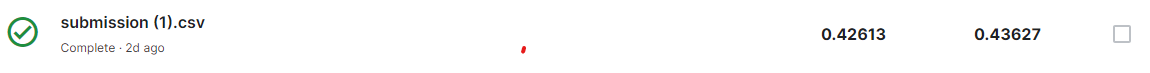

# 3. MLPClassifier

接著第三個方法我嘗試使用 MLPClassifier 來進行分類。MLPClassifier 是 Scikit-learn 中的多層感知器（Multilayer Perceptron，MLP）的分類器，通過設定不同的參數，可以構建不同結構的神經網絡模型來解決分類問題。在使用時，可以根據具體問題調整參數以達到最佳性能。不過這邊唯一的問題就是在前處理時我們必須將 text 轉唯一連串的數字。

首先我們 import 我們所需要的 package

In [ ]:
import pandas as pd
import numpy as np
import json
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

讀進我們所需的檔案

In [ ]:
df=pd.read_json("tweets_DM.json",lines=True,orient='columns')
op=pd.json_normalize(df._source)
op=op.rename(columns={'tweet.tweet_id':'tweet_id','tweet.text':'text'})
ident=pd.read_csv("data_identification.csv")
emo=pd.read_csv("emotion.csv")

將檔案合併，變成我們所需的檔案，這樣就只需呼叫一次，然後根據 identification 的類別進行訓練跟測試資料集的分類

In [ ]:
total=pd.merge(op,ident,on='tweet_id')
total=total.drop(columns='tweet.hashtags')
train_data=total[total['identification']=='train']
test_data=total[total['identification']=='test']

In [ ]:
train_data=pd.merge(train_data,emo,on='tweet_id')

In [ ]:
train_data=train_data.drop(columns='identification')
test_data=test_data.drop(columns='identification')

將我們整理好的檔案儲存起來，下次呼叫即可省略前處理的步驟

In [ ]:
train_data.to_pickle("train_df.pkl")
test_data.to_pickle("test_df.pkl")

In [ ]:
train_data=pd.read_pickle("train_df.pkl")
test_data=pd.read_pickle("test_df.pkl")

接著我們在訓練數據集的文本列中移除特定的字符

In [ ]:
train_data['text']=train_data['text'].replace('#',"")
train_data['text']=train_data['text'].replace('@',"")

將文本轉換為 BOW 表示形式所需的信息。每個文本將被表示為一個稀疏的向量，其中每個元素對應一個詞彙，其值為該詞在文本中出現的次數。這種表示法可以用於訓練機器學習模型，例如使用支持向量機（SVM）或其他分類器。

In [ ]:
BOW = CountVectorizer(max_features=200000, tokenizer=nltk.word_tokenize)
BOW.fit(train_data['text'])

c:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_features=200000,
                tokenizer=<function word_tokenize at 0x000001F23853E020>)

切分我們的訓練集跟測試集

In [ ]:
train_da, val_da = train_test_split(train_data, random_state=777, train_size=0.85)

In [ ]:
tr_x=train_da
val_x=val_da

將資料集轉為 BOW 的稀疏矩陣

In [ ]:
train_x=BOW.transform(tr_x['text'])
val_x=BOW.transform(val_x['text'])
train_y=tr_x['emotion']

In [ ]:
val_y=val_da['emotion']

In [ ]:
test_x=BOW.transform(test_data['text'])

使用 Scikit-learn 中的 LabelEncoder 來對目標標籤進行編碼，同時使用 Keras 的 to_categorical 函數將整數編碼轉換為 one-hot 編碼，目的是將目標標籤轉換為模型可以使用的形式

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
label_encoder = LabelEncoder()
label_encoder.fit(train_y)
print( label_encoder.classes_)


def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, train_y)

['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']


使用 MLP 分類器進行文本分類，並根據指定的參數進行訓練。這種分類器在處理非線性分類問題時通常表現良好，同時使用 tanh 激活函數和 Adam 優化算法有助於更好地捕捉複雜的模型模式

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
NN2=MLPClassifier(activation='tanh',solver='adam',alpha=0.001,power_t=0.5,max_iter=15,hidden_layer_sizes=(32,32,32),verbose=True,early_stopping=False)
NN2=NN2.fit(train_x,y_train)

mlp_pre2=NN2.predict(train_x)
print("train accu:",accuracy_score(mlp_pre2,y_train))

mlp_pre_test2=NN2.predict(test_x)

Iteration 1, loss = 1.30426807
Iteration 2, loss = 1.23602071
Iteration 3, loss = 1.21038376
Iteration 4, loss = 1.19126605
Iteration 5, loss = 1.17530179
Iteration 6, loss = 1.16160674
Iteration 7, loss = 1.14950047
Iteration 8, loss = 1.13846832
Iteration 9, loss = 1.12864127
Iteration 10, loss = 1.11967616
Iteration 11, loss = 1.11155433
Iteration 12, loss = 1.10387703
Iteration 13, loss = 1.09712904
Iteration 14, loss = 1.09111440
Iteration 15, loss = 1.08504672
train accu: 0.6640391850446958


去計算我們訓練後模型的精確度

In [33]:
df_test = df_all[df_all['identification'] == 'test'].dropna(subset=['text'])
mlp_pre_test2=pd.DataFrame(mlp_pre_test2)
y_submit=df_test.copy()
y_submit['emotion']=list(mlp_pre_test2[0])
y_submit.drop(labels=['text','score','identification'],axis=1,inplace=True)
y_submit.rename(columns={"tweet_id": "id"},inplace=True)

最後利用訓練好的模型來進行，並將最後結果存成 csv 黨，以供我們繳交

In [ ]:
df_test = df_all[df_all['identification'] == 'test']
del df_test['score']
del df_test['identification']

In [ ]:
add=df_test[df_test['text'].isna()].copy()
add['emotion']='joy'
add.rename(columns={'tweet_id':'id'},inplace=True)
y_submit=pd.concat([y_submit,add])
y_submit.to_csv('submission.csv',index=False)

我用的這個方法得到了 0.44111 的精度，表現算是中規中矩，不過我認為精度沒有下面的方法好可能是由於模型配置、數據特性或超參數的不同，但是也是一個不錯的嘗試。
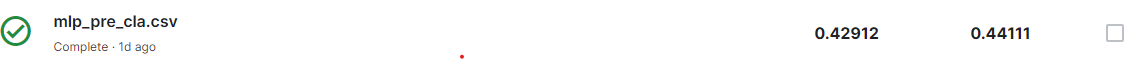

# 4. MLPRegressor

MLPRegressor 是一種靈活且強大的模型，適用於各種回歸任務。根據任務的複雜性，您可以通過調整超參數和模型配置來優化模型的性能，且我們資料前處理的方式跟 3. 一樣，所以這邊只針對後續不同的程式碼做解釋

使用 Scikit-learn 中的 MLPRegressor 類建立了一個多層感知器（MLP）回歸模型，然後使用訓練數據進行模型的擬合（fitting）

In [ ]:
from sklearn.neural_network import MLPRegressor
NN=MLPRegressor(activation='logistic',solver='adam',alpha=0.00007,max_iter=10,hidden_layer_sizes=(32,32,32),verbose=True,early_stopping=False)
NN=NN.fit(train_x,y_train)

Iteration 1, loss = 0.04198441
Iteration 2, loss = 0.03987347
Iteration 3, loss = 0.03984978
Iteration 4, loss = 0.03962646
Iteration 5, loss = 0.03928424
Iteration 6, loss = 0.03897174
Iteration 7, loss = 0.03869748
Iteration 8, loss = 0.03844560
Iteration 9, loss = 0.03823408
Iteration 10, loss = 0.03805328


c:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


去計算我們訓練後模型的精確度

In [ ]:
from sklearn.metrics import accuracy_score
mlp_pre=NN.predict(train_x)
mlp_pre_val=NN.predict(val_x)
mlp_pre=label_decode(label_encoder,mlp_pre)
mlp_pre_val=label_decode(label_encoder,mlp_pre_val)
print("train accu:",accuracy_score(mlp_pre,train_y))
print("val accu:",accuracy_score(mlp_pre_val,val_y))

train accu: 0.6944201068840989
val accu: 0.5843588980236792


最後利用訓練好的模型來進行，並將最後結果存成 csv 黨，以供我們繳交

In [ ]:
mlp_pre_test=NN.predict(test_x)
mlp_pre_test=label_decode(label_encoder,mlp_pre_test)
output5= pd.DataFrame({'id':test_data.tweet_id , 'emotion': mlp_pre_test})
output5.to_csv('submission_2.csv', index=False)

這個方法是我得到最高分數的一個方法，雖然因為我的 max features 設定很大，所以導致訓練幾乎花了10個小時，但能得到這樣的0.48209的結果，我還是非常開心的，我個人認為這個方法的表現比較好有幾個可能：
1. 使用 Bag of Words（BOW）作為文本表示形式，它將文本轉換為詞袋模型，考慮每個單詞的出現頻率。MLP 可以從這樣的表示中學習到更複雜的特徵和模式，有助於提高文本分類的性能
2. 非線性建模

不過因為時間的限制，我個人認為有些參數如果再進行優化，我們能得到更好的結果
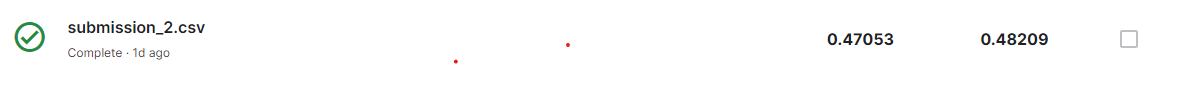

# 5. 其餘嘗試

其實這次的作業我是非常想要使用 BERT 來進行訓練，所以花了非常非常多的時間要來使用 BERT，不過非常可惜到最後都沒有成功，下方是我撰寫使用 BERT 的程式碼，不過因為無法成功執行，所以我就不多做講解，在這邊稍微講一下我的設計概念就好了：

1. 首先我將 emotion 的部分轉為數字，方便我進行後續訓練
2. 使用BertTokenizer來創造我們的Tokenizer，然後這邊我使用 bert-base-uncased 作為一開始的參數，這是以英文text來做訓練的參數，並且沒有大小寫的區分
3. 然後使用Tokenizer為我們的text進行 encode ，這邊還有順帶做了 mask 的處理
4. 最後用BertForSequenceClassification當作我們的模型來進行訓練

以上是我設計的步驟，不過非常可惜的並沒有成功，希望我之後能成功研究出來。

我同時也有嘗試另一個想法，就是先就由BERT做encoder的動作前處理我們的資料，在將這些資訊丟到其他分類模型中訓練，不過很可惜，我一樣在這個嘗試中失敗了。

Bert測試

In [1]:
import pandas as pd
df_all=pd.read_csv('kaggle_data_preprocess.csv')
df_all.drop(['Unnamed: 0'], axis=1, inplace=True)
df_all.drop(labels=['identification_x','emotion_x'], axis=1, inplace=True)
df_all.rename(columns={"tweet_id": "tweet_id", "identification_y": "identification", "emotion_y":"emotion"}, inplace=True)
df_all

,tweet_id,text,score,identification,emotion
0,0x376b20,people post add #snapchat must dehydrated cuz ...,0.381232,train,anticipation
1,0x2d5350,see trump dangerous #freepress around world #t...,0.422287,train,sadness
2,0x28b412,confident obedience write knowing even ask (ph...,0.225806,test,NaN
3,0x1cd5b0,issa stalking tasha 😂😂😂,0.366569,train,fear
4,0x2de201,trust faith friend someone trust putting faith...,0.965787,test,NaN
...,...,...,...,...,...
1867530,0x316b80,buy last 2 ticket remaining show sell #mixedfe...,0.807429,test,NaN
1867531,0x29d0cb,swear hard work gone pay one day😈💰💸,0.358749,test,NaN
1867532,0x2a6a4f,card left wasnt idea get parcel,0.485826,test,NaN
1867533,0x24faed,ah corporate life date using relative anachron...,0.820137,train,joy


In [2]:
emotion_mapping = {'joy':0,
                   'anticipation':1,
                   'trust':2,
                   'sadness':3,
                   'disgust':4,
                   'fear':5,
                   'surprise':6,
                   'anger':7
                  }
df_all['emotion'] = df_all['emotion'].map(emotion_mapping)
df_all

,tweet_id,text,score,identification,emotion
0,0x376b20,people post add #snapchat must dehydrated cuz ...,0.381232,train,1.0
1,0x2d5350,see trump dangerous #freepress around world #t...,0.422287,train,3.0
2,0x28b412,confident obedience write knowing even ask (ph...,0.225806,test,NaN
3,0x1cd5b0,issa stalking tasha 😂😂😂,0.366569,train,5.0
4,0x2de201,trust faith friend someone trust putting faith...,0.965787,test,NaN
...,...,...,...,...,...
1867530,0x316b80,buy last 2 ticket remaining show sell #mixedfe...,0.807429,test,NaN
1867531,0x29d0cb,swear hard work gone pay one day😈💰💸,0.358749,test,NaN
1867532,0x2a6a4f,card left wasnt idea get parcel,0.485826,test,NaN
1867533,0x24faed,ah corporate life date using relative anachron...,0.820137,train,0.0


In [3]:
grouped_df = df_all.groupby('identification')
test_data_all = grouped_df.get_group('test')
train_data_all = grouped_df.get_group('train')

train_data=test_data_all.dropna(subset=["text"])
test_data=train_data_all.dropna(subset=['text'])


In [4]:
train_data.drop(labels=['identification','score'], axis=1, inplace=True)
test_data.drop(labels=['identification','score'], axis=1, inplace=True)
test_data

C:\Users\nick2\AppData\Local\Temp\ipykernel_11808\1798278108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(labels=['identification','score'], axis=1, inplace=True)
C:\Users\nick2\AppData\Local\Temp\ipykernel_11808\1798278108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(labels=['identification','score'], axis=1, inplace=True)


,tweet_id,text,emotion
0,0x376b20,people post add #snapchat must dehydrated cuz ...,1.0
1,0x2d5350,see trump dangerous #freepress around world #t...,3.0
3,0x1cd5b0,issa stalking tasha 😂😂😂,5.0
5,0x1d755c,thx best time tonight stories! eartbreakingly ...,0.0
6,0x2c91a8,still waiting supply iscus,1.0
...,...,...,...
1867526,0x321566,im appy!!! #nowonder name show! #appy! 👏👏👏👏👏,0.0
1867527,0x38959e,every circumtance id like thankful almighty je...,0.0
1867528,0x2cbca6,there currently two girl walking around librar...,0.0
1867533,0x24faed,ah corporate life date using relative anachron...,0.0


In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda


In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 步驟 2: 數據預處理
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 64

In [8]:
def tokenize_and_format(text_list):
    tokenized_texts = []
    attention_masks = []

    for text in text_list:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        tokenized_texts.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return tokenized_texts, attention_masks

In [9]:
train_tokenized_texts, train_attention_masks = tokenize_and_format(train_data['text'])
test_tokenized_texts, test_attention_masks = tokenize_and_format(test_data['text'])
train_labels = torch.tensor(train_data['emotion'].values)
test_labels = torch.tensor(test_data['emotion'].values)

In [10]:
train_dataset = TensorDataset(torch.cat(train_tokenized_texts, dim=0), torch.cat(train_attention_masks, dim=0), train_labels)
test_dataset = TensorDataset(torch.cat(test_tokenized_texts, dim=0), torch.cat(test_attention_masks, dim=0), test_labels)

In [11]:
# 創建 DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 加載模型
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=8)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
import torch
# 設置優化器
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# 訓練模型
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        # 將數據移到 GPU
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        if step % 40 == 0 and step != 0:
            print('Batch {:>5,} of {:>5,}. Loss: {:>5,}'.format(step, len(train_dataloader), loss.item()))

    print('Epoch {:>5,} Average training loss: {:>5,}'.format(epoch, total_loss / len(train_dataloader)))

print("Training completed.")